In [1]:
import pandas as pd
passenger_train=pd.read_csv('train.csv')
target_col='Survived'
id_col='PassengerId'
target=passenger_train[target_col]
total_num=len(passenger_train)

In [2]:
# drop useless cols
c=passenger_train.count()
drop_cols=c[c*2<len(passenger_train)].index
drop_cols=list(drop_cols)
drop_cols+=[id_col,target_col,'Name','Ticket']
passenger_train.drop(drop_cols,axis=1,inplace=True)

In [3]:
passenger_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


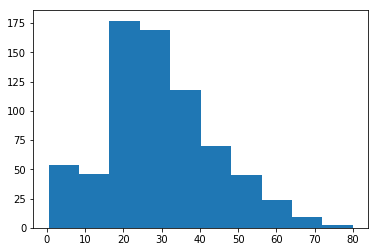

In [4]:
%matplotlib inline
from matplotlib import pyplot

pyplot.hist(passenger_train['Age'].dropna())
pyplot.show()

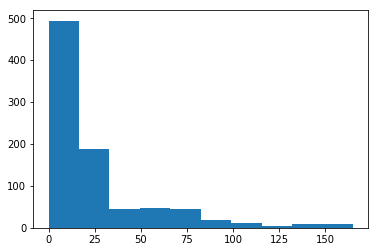

In [5]:
%matplotlib inline
from matplotlib import pyplot

pyplot.hist(passenger_train[passenger_train['Fare']<200]['Fare'].dropna())
pyplot.show()

In [6]:
import sys
sys.path.append('../')
from util import *

In [7]:
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer,LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

summary=passenger_train.describe()
num_imputer=Imputer(strategy='median')

num_pl=Pipeline([
    ('select',DataFrameSelecter(summary.columns)),
    ('fill',Imputer(strategy='median')),
    ('scale',StandardScaler()),
])
num_pl.fit(passenger_train)

cat_cols=list(set(passenger_train.columns)-set(summary.columns))
pls=[Pipeline([
    ('select',DataFrameSelecter2(c)),
    ('drop',NanDropper()),
    ('encode',LabelBinarizer()),
]) for c in cat_cols ]

[pls[i].fit_transform(passenger_train) for i in range(len(cat_cols))]

cat_pls=[(cat_cols[i],Pipeline([
    ('select',DataFrameSelecter3(cat_cols[i])),
    ('encode',pls[i].named_steps['encode']),
])) for i in range(len(cat_cols))]

full_pl=FeatureUnion(transformer_list=[('num',num_pl)]+cat_pls)

prepared_passenger_train_data=full_pl.transform(passenger_train)

# add new cat cols
new_cat_cols=[]
g=lambda i,c: '%s_%s'%(cat_cols[i],c) if len(pls[i].named_steps['encode'].classes_)>2 else None
for i in range(len(cat_cols)):
    for c in pls[i].named_steps['encode'].classes_:
        if len(pls[i].named_steps['encode'].classes_)>2:
            new_cat_cols.append('%s_%s'%(cat_cols[i],c))
        else:
            if cat_cols[i] not in new_cat_cols:
                new_cat_cols.append(cat_cols[i])
new_cat_cols

# delete origin cat cols
cols=list(passenger_train.columns)
[cols.remove(c) for c in cat_cols]

# build new df
prepared_passenger_train=pd.DataFrame(prepared_passenger_train_data,columns=cols+new_cat_cols)
prepared_passenger_train.head()


,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked_C,Embarked_Q,Embarked_S
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,0.0,0.0,1.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,1.0,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,0.0,0.0,1.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,0.0,0.0,1.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,0.0,0.0,1.0


In [8]:
passenger_test=pd.read_csv('test.csv')
test_id=passenger_test[id_col]
drop_cols.remove(target_col)
passenger_test.drop(drop_cols,axis=1,inplace=True)
prepared_passenger_test=full_pl.transform(passenger_test)

## gradient boosting tree

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()

from sklearn.model_selection import cross_val_score

scores=cross_val_score(gbc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()


0.83395386448757236

kaggle score:0.78469 rank: 3086

In [10]:
import time
time.time()

1500802274.9865792

### tune params

In [11]:
# from sklearn.model_selection import GridSearchCV
# t1=time.time()
# param_grid={'max_depth':[2,3,5,8],'n_estimators':[50,100,150],'learning_rate':[0.1,0.01]}
# clf=GridSearchCV(GradientBoostingClassifier(),param_grid,scoring='accuracy',cv=10,n_jobs=4)
# clf.fit(prepared_passenger_train,target)
# print(clf.best_score_,clf.best_params_,time.time()-t1)

In [12]:
# survived=clf.predict(prepared_passenger_test)
# df=pd.DataFrame({id_col:test_id,target_col:survived})
# df.to_csv('result.csv',index=False)

kaggle score:0.78469 rank: 3073

## random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()

from sklearn.model_selection import cross_val_score

scores=cross_val_score(rfc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()



0.80823629553966625

not better

In [14]:
from sklearn.svm import SVC
# clf=LinearSVC(C=1,loss='hinge')
svc=SVC(kernel='poly',probability=True)

from sklearn.model_selection import cross_val_score
scores=cross_val_score(svc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()

0.78467767563273172

## draw validation curve

In [15]:

from sklearn.model_selection import validation_curve

train_scores,test_scores=validation_curve(svc,prepared_passenger_train,target,scoring='roc_auc',param_name='C',param_range=[1],cv=20)
print(train_scores,test_scores)

[[ 0.88278121  0.87794721  0.88518825  0.8776613   0.88091245  0.88291747
   0.87836114  0.87694965  0.87071017  0.87893899  0.87520483  0.87615679
   0.87879163  0.87060713  0.87800177  0.87847333  0.87448571  0.87509579
   0.87060124  0.87118774]] [[ 0.75        0.88293651  0.74789916  0.89915966  0.82773109  0.69327731
   0.90021008  0.93487395  0.90756303  0.82135076  0.81699346  0.8627451
   0.8453159   0.84640523  0.86928105  0.70588235  0.86492375  0.96078431
   0.88453159  0.93464052]]


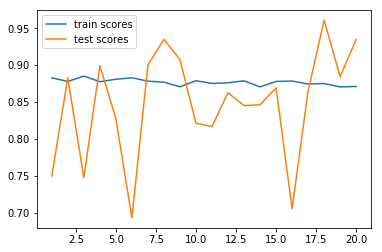

In [16]:
%matplotlib inline
from matplotlib import pyplot

xaxis=[i for i in range(1,len(train_scores[0])+1)]
pyplot.plot(xaxis,train_scores[0],label='train scores')
pyplot.plot(xaxis,test_scores[0],label='test scores')
pyplot.legend()
pyplot.show()

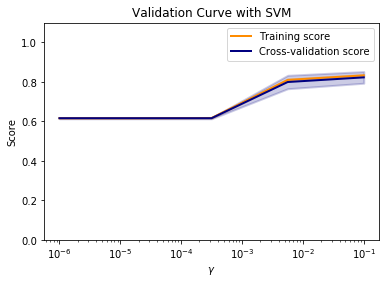

In [17]:
import matplotlib.pyplot as plt
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), prepared_passenger_train, target, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

use ensemble methods

In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

vote=VotingClassifier(estimators=[('gbc',gbc),('rfc',rfc),('svc',svc)],voting='soft')
scores=cross_val_score(vote,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()

0.82270514130064698

## stacking

In [38]:
from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner

# Creating Ensemble
ensemble = Ensemble([gbc, rfc, svc])
eclf = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))

# from sklearn.model_selection import cross_val_score
# scores=cross_val_score(eclf,prepared_passenger_train,target,scoring='accuracy',cv=10)
eclf.fit(prepared_passenger_train,target)
eclf.score(prepared_passenger_train,target)

0.9135802469135802

In [48]:
survived=eclf.predict(prepared_passenger_test)
survived=[int(s) for s in survived]
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)

In [49]:
# Creating Stacking
layer_1 = Ensemble([gbc, rfc, svc])
layer_2 = Ensemble([sklearn.clone(gbc)])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)
sclf.fit(prepared_passenger_train,target)

survived=eclf.predict(prepared_passenger_test)
survived=[int(s) for s in survived]
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)

KeyError: '[284 285 287 292 293 294 295 296 297 302 304 308 309 310 311 312 313 314\n 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332\n 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350\n 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368\n 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386\n 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404\n 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422\n 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440\n 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458\n 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476\n 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494\n 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512\n 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530\n 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548\n 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566\n 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584\n 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602\n 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620\n 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638\n 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656\n 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674\n 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692\n 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710\n 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728\n 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746\n 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764\n 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782\n 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800\n 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818\n 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836\n 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854\n 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872\n 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890] not in index'

In [40]:
help(sclf)

Help on EnsembleStackClassifier in module brew.stacking.stacker object:

class EnsembleStackClassifier(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, stack, combiner=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, X, y)
 |  
 |  predict(self, X)
 |  
 |  predict_proba(self, X)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

